In [1]:
%matplotlib inline


.. currentmodule:: dgl

PageRank with DGL Message Passing
=================================

**Author**: `Minjie Wang <https://jermainewang.github.io/>`_, Quan Gan, Yu Gai,
Zheng Zhang

In this section we illustrate the usage of different levels of message
passing API with PageRank on a small graph. In DGL, the message passing and
feature transformations are all **User-Defined Functions** (UDFs).

The goal of this tutorial: to implement PageRank using DGL message passing
interface.



The PageRank Algorithm
----------------------
In each iteration of PageRank, every node (web page) first scatters its
PageRank value uniformly to its downstream nodes. The new PageRank value of
each node is computed by aggregating the received PageRank values from its
neighbors, which is then adjusted by the damping factor:

\begin{align}PV(u) = \frac{1-d}{N} + d \times \sum_{v \in \mathcal{N}(u)}
   \frac{PV(v)}{D(v)}\end{align}

where $N$ is the number of nodes in the graph; $D(v)$ is the
out-degree of a node $v$; and $\mathcal{N}(u)$ is the neighbor
nodes.



A naive implementation
----------------------
Let us first create a graph with 100 nodes with NetworkX and convert it to a
:class:`DGLGraph`:



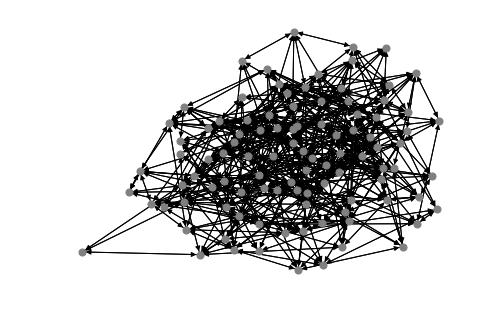

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

According to the algorithm, PageRank consists of two phases in a typical
scatter-gather pattern. We first initialize the PageRank value of each node
to $\frac{1}{N}$ and store each node's out-degree as a node feature:



In [3]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

We then define the message function, which divides every node's PageRank
value by its out-degree and passes the result as message to its neighbors:



In [4]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In DGL, the message functions are expressed as **Edge UDFs**.  Edge UDFs
take in a single argument ``edges``.  It has three members ``src``, ``dst``,
and ``data`` for accessing source node features, destination node features,
and edge features respectively.  Here, the function computes messages only
from source node features.

Next, we define the reduce function, which removes and aggregates the
messages from its ``mailbox``, and computes its new PageRank value:



In [5]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

The reduce functions are **Node UDFs**.  Node UDFs have a single argument
``nodes``, which has two members ``data`` and ``mailbox``.  ``data``
contains the node features while ``mailbox`` contains all incoming message
features, stacked along the second dimension (hence the ``dim=1`` argument).

The message UDF works on a batch of edges, whereas the reduce UDF works on
a batch of edges but outputs a batch of nodes. Their relationships are as
follows:

![](https://i.imgur.com/kIMiuFb.png)


We register the message function and reduce function, which will be called
later by DGL.



In [6]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

The algorithm is then very straight-forward. Here is the code for one
PageRank iteration:



In [7]:
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

Improvement with batching semantics
-----------------------------------
The above code does not scale to large graph because it iterates over all
the nodes. DGL solves this by letting user compute on a *batch* of nodes or
edges. For example, the following codes trigger message and reduce functions
on multiple nodes and edges at once.



In [8]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

Note that we are still using the same reduce function ``pagerank_reduce_func``,
where ``nodes.mailbox['pv']`` is a *single* tensor, stacking the incoming
messages along the second dimension.

Naturally, one will wonder if this is even possible to perform reduce on all
nodes in parallel, since each node may have different number of incoming
messages and one cannot really "stack" tensors of different lengths together.
In general, DGL solves the problem by grouping the nodes by the number of
incoming messages, and calling the reduce function for each group.



More improvement with higher level APIs
---------------------------------------
DGL provides many routines that combines basic ``send`` and ``recv`` in
various ways. They are called **level-2 APIs**. For example, the PageRank
example can be further simplified as follows:



In [9]:
def pagerank_level2(g):
    g.update_all()

Besides ``update_all``, we also have ``pull``, ``push``, and ``send_and_recv``
in this level-2 category. Please refer to the :doc:`API reference <../../api/python/graph>`
for more details.



Even more improvement with DGL builtin functions
------------------------------------------------
As some of the message and reduce functions are very commonly used, DGL also
provides **builtin functions**. For example, two builtin functions can be
used in the PageRank example.

* :func:`dgl.function.copy_src(src, out) <function.copy_src>`
  is an edge UDF that computes the
  output using the source node feature data. User needs to specify the name of
  the source feature data (``src``) and the output name (``out``).

* :func:`dgl.function.sum(msg, out) <function.sum>` is a node UDF
  that sums the messages in
  the node's mailbox. User needs to specify the message name (``msg``) and the
  output name (``out``).

For example, the PageRank example can be rewritten as following:



In [10]:
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

Here, we directly provide the UDFs to the :func:`update_all <DGLGraph.update_all>`
as its arguments.
This will override the previously registered UDFs.

In addition to cleaner code, using builtin functions also gives DGL the
opportunity to fuse operations together, resulting in faster execution.  For
example, DGL will fuse the ``copy_src`` message function and ``sum`` reduce
function into one sparse matrix-vector (spMV) multiplication.

`This section <spmv_>`_ describes why spMV can speed up the scatter-gather
phase in PageRank.  For more details about the builtin functions in DGL,
please read the :doc:`API reference <../../api/python/function>`.

You can also download and run the codes to feel the difference.



In [11]:
for k in range(K):
    # Uncomment the corresponding line to select different version.
    # pagerank_naive(g)
    # pagerank_batch(g)
    # pagerank_level2(g)
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0114, 0.0106, 0.0069, 0.0094, 0.0089, 0.0085, 0.0071, 0.0152, 0.0070,
        0.0063, 0.0092, 0.0130, 0.0088, 0.0070, 0.0044, 0.0111, 0.0072, 0.0114,
        0.0106, 0.0125, 0.0108, 0.0119, 0.0123, 0.0096, 0.0077, 0.0070, 0.0096,
        0.0142, 0.0079, 0.0134, 0.0080, 0.0095, 0.0122, 0.0107, 0.0106, 0.0086,
        0.0078, 0.0124, 0.0133, 0.0068, 0.0060, 0.0104, 0.0091, 0.0148, 0.0061,
        0.0087, 0.0116, 0.0112, 0.0195, 0.0115, 0.0105, 0.0089, 0.0088, 0.0061,
        0.0108, 0.0123, 0.0089, 0.0135, 0.0126, 0.0179, 0.0113, 0.0060, 0.0070,
        0.0097, 0.0096, 0.0105, 0.0113, 0.0096, 0.0125, 0.0062, 0.0087, 0.0092,
        0.0104, 0.0159, 0.0077, 0.0102, 0.0121, 0.0078, 0.0087, 0.0070, 0.0079,
        0.0129, 0.0070, 0.0096, 0.0104, 0.0099, 0.0098, 0.0105, 0.0099, 0.0069,
        0.0131, 0.0108, 0.0105, 0.0124, 0.0079, 0.0087, 0.0098, 0.0097, 0.0096,
        0.0117])


/home/honda/anaconda3/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)



Using spMV for PageRank
-----------------------
Using builtin functions allows DGL to understand the semantics of UDFs and
thus allows more efficient implementation for you. For example, in the case
of PageRank, one common trick to accelerate it is using its linear algebra
form.

\begin{align}\mathbf{R}^{k} = \frac{1-d}{N} \mathbf{1} + d \mathbf{A}*\mathbf{R}^{k-1}\end{align}

Here, $\mathbf{R}^k$ is the vector of the PageRank values of all nodes
at iteration $k$; $\mathbf{A}$ is the sparse adjacency matrix
of the graph.
Computing this equation is quite efficient because there exists efficient
GPU kernel for the *sparse-matrix-vector-multiplication* (spMV). DGL
detects whether such optimization is available through the builtin
functions. If the certain combination of builtins can be mapped to a spMV
kernel (e.g. the pagerank example), DGL will use it automatically. As a
result, *we recommend using builtin functions whenever it is possible*.



Next steps
----------

It is time to move on to some real models in DGL.

* Check out the :doc:`overview page<../models/index>`
  of all the model tutorials.
* Would like to know more about Graph Neural Networks? Start with the
  :doc:`GCN tutorial<../models/1_gnn/1_gcn>`.
* Would like to know how DGL batches multiple graphs? Start with the
  :doc:`TreeLSTM tutorial<../models/2_small_graph/3_tree-lstm>`.
* Would like to play with some graph generative models? Start with our tutorial
  on the :doc:`Deep Generative Model of Graphs<../models/3_generative_model/5_dgmg>`.
* Would like to see how traditional models are interpreted in a view of graph?
  Check out our tutorials on :doc:`CapsuleNet<../models/4_old_wines/2_capsule>` and
  :doc:`Transformer<../models/4_old_wines/7_transformer>`.

